In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import mesa_reader as mr
from scipy import interpolate
import emcee
import corner

In [2]:
matplotlib.rcParams['figure.facecolor'] = 'white'

In [3]:
mearth = 5.97e27
msun = 1.9892e33
rearth = 6.371008e8
rsun = 6.9598e10
rfrac = rsun/rearth
mfrac = msun/mearth

In [4]:
def formatstring(myfloat):
    return '%.5f'%myfloat

In [5]:
npzfile = np.load('146c_data.npz',allow_pickle=True)
masses = npzfile['masses']
radii = npzfile['radii']
fs = npzfile['fs']
ages = npzfile['ages']

In [25]:
initial_masses = np.arange(6.7,8.4+0.1,0.1)
initial_fs = [0.001, 0.002, 0.003] + list(np.arange(0.004, 0.034+0.002, 0.002))
initial_fs = np.array(initial_fs)
print(initial_masses)

[6.7 6.8 6.9 7.  7.1 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4]


In [7]:
final_masses = np.array([masses[i][-1] for i in range(len(masses))])
final_fs = np.array([fs[i][-1] for i in range(len(fs))])
final_radii = np.array([radii[i][-1] for i in range(len(radii))])
final_ages = np.array([ages[i][-1] for i in range(len(ages))])

In [8]:
grid_fs, grid_ms = np.meshgrid(initial_fs, initial_masses)
grid_fs, grid_ms = grid_fs.flatten(), grid_ms.flatten()
grid_points = np.column_stack((grid_ms, grid_fs))
print(grid_points.shape)
print(final_radii.shape)

(342, 2)
(342,)


In [9]:
#age interpolation
radii_5gyr = []
masses_5gyr = []
newage = 5.0e9

for i in range(0,len(ages)):
    if ages[i][-1] < newage:
        radii_5gyr.append(np.nan)
        masses_5gyr.append(np.nan)
        
    else:
        radii_age_interp = interpolate.interp1d(ages[i],radii[i],kind='linear')
        radii_5gyr.append(radii_age_interp(newage))
        
        masses_age_interp = interpolate.interp1d(ages[i],masses[i],kind='linear')
        masses_5gyr.append(masses_age_interp(newage))

In [26]:
#final mass, radius interpolation from intial values

radius_interp = interpolate.LinearNDInterpolator(grid_points,radii_5gyr)

mass_interp = interpolate.LinearNDInterpolator(grid_points,masses_5gyr)

In [27]:
mass_interp(7.75, 0.0041)
radius_interp(7.75, 0.0041)

array(2.00573554)

In [28]:
#test? likelihood function
def log_likelihood(x, mu_m, sigma_m, mu_r, sigma_r):
    #2 dimensions, mass and radius
    #K2-146c: measured mass m = 7.50 +/- 0.23 M_E
    #measured radius 2.19 +/- 0.07 R_E
    #x[0] = mass
    #x[1] = f
    
    #Gaussian likelihood
    #up to constant?
    lval = - 0.5 * ( (( (mass_interp(x[0],x[1]) - mu_m) / sigma_m ) ** 2) + (( (radius_interp(x[0],x[1]) - mu_r) / sigma_r ) ** 2) )
    
    if np.isnan(lval):
        lval = -np.inf
    
    return lval

In [29]:
ndim = 2
nwalkers = 16

p0 = np.random.rand(nwalkers, ndim)
p0[:,0] = p0[:,0] + 7.0
p0[:,1] = p0[:,1] * 0.01 + 0.004 

In [30]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[7.50, 0.23, 2.19, 0.07], moves=[emcee.moves.StretchMove(a=4.0)])

In [31]:
state = sampler.run_mcmc(p0,500)
sampler.reset()

In [32]:
var = sampler.run_mcmc(state,10000)

Text(0, 0.5, 'p($m_p$)')

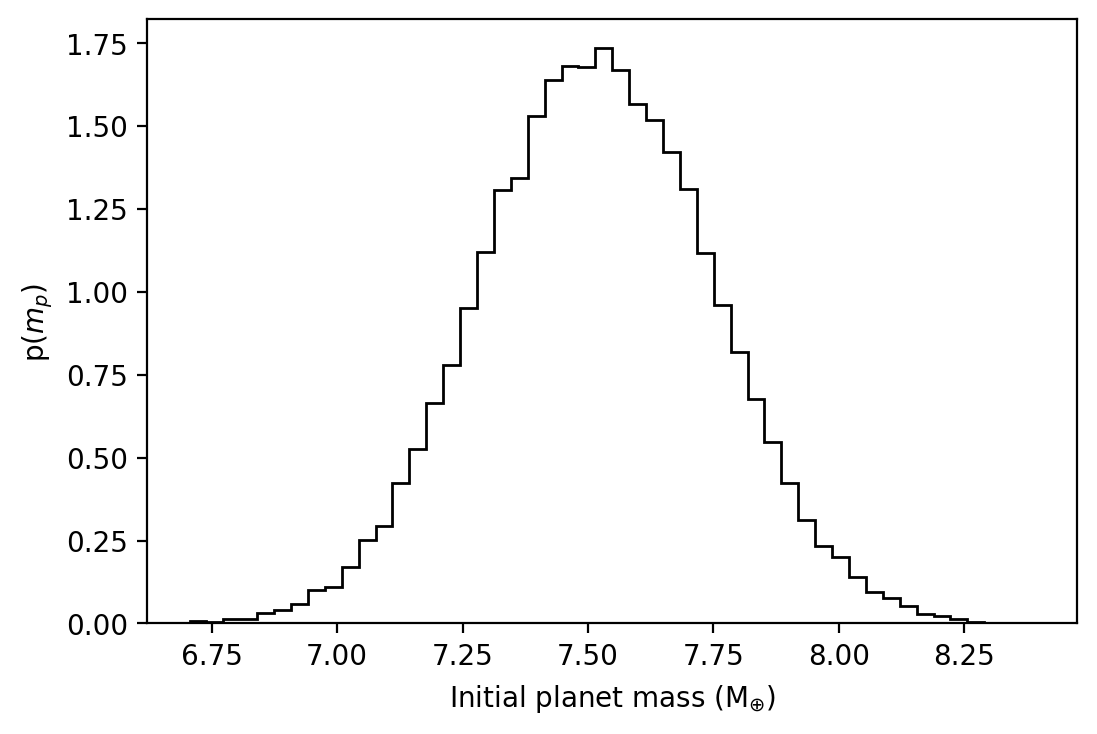

In [33]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:,0],50,color='k',histtype='step',density=True)
plt.gcf().set_dpi(200)
axm = plt.gca()
axm.set_xlabel('Initial planet mass (M$_{\oplus}$)')
axm.set_ylabel('p($m_p$)')

In [34]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print("Autocorrelation time: {0:.2f} steps".format(sampler.get_autocorr_time()[0]))

Mean acceptance fraction: 0.494
Autocorrelation time: 18.99 steps


Text(0, 0.5, 'p($f$)')

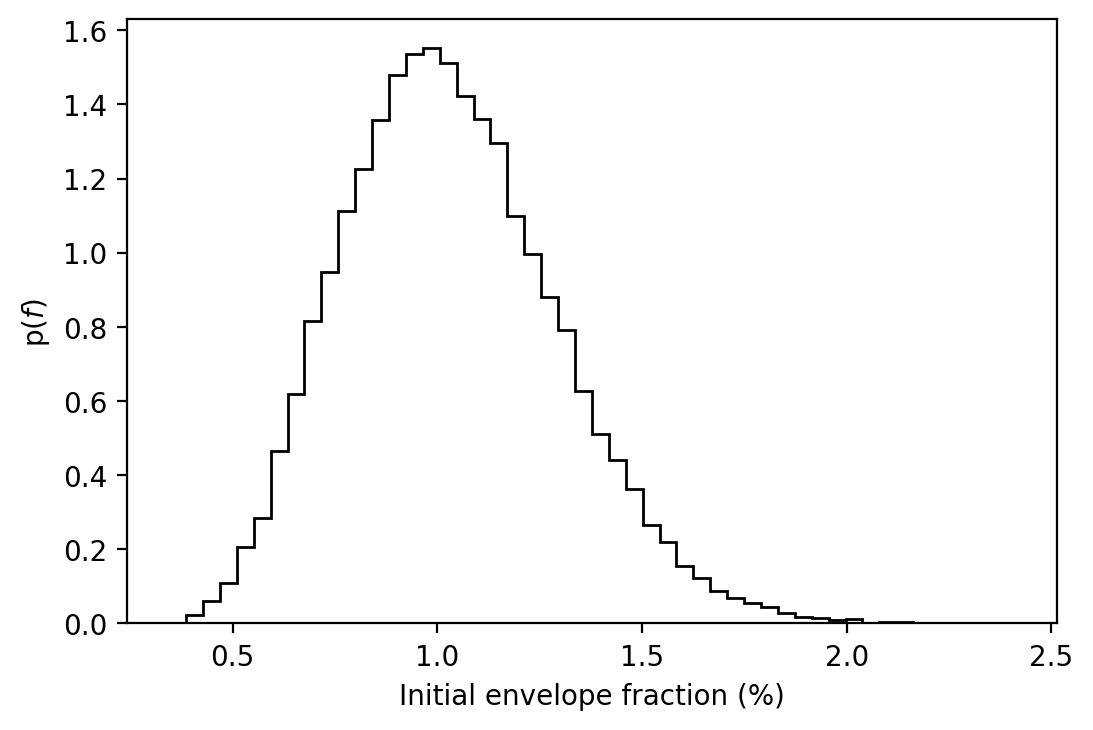

In [35]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:,1]*100,50,color='k',histtype='step',density=True)
plt.gcf().set_dpi(200)
axf = plt.gca()
axf.set_xlabel('Initial envelope fraction (%)')
axf.set_ylabel('p($f$)')

Text(0.5, 0.98, 'K2-146c')

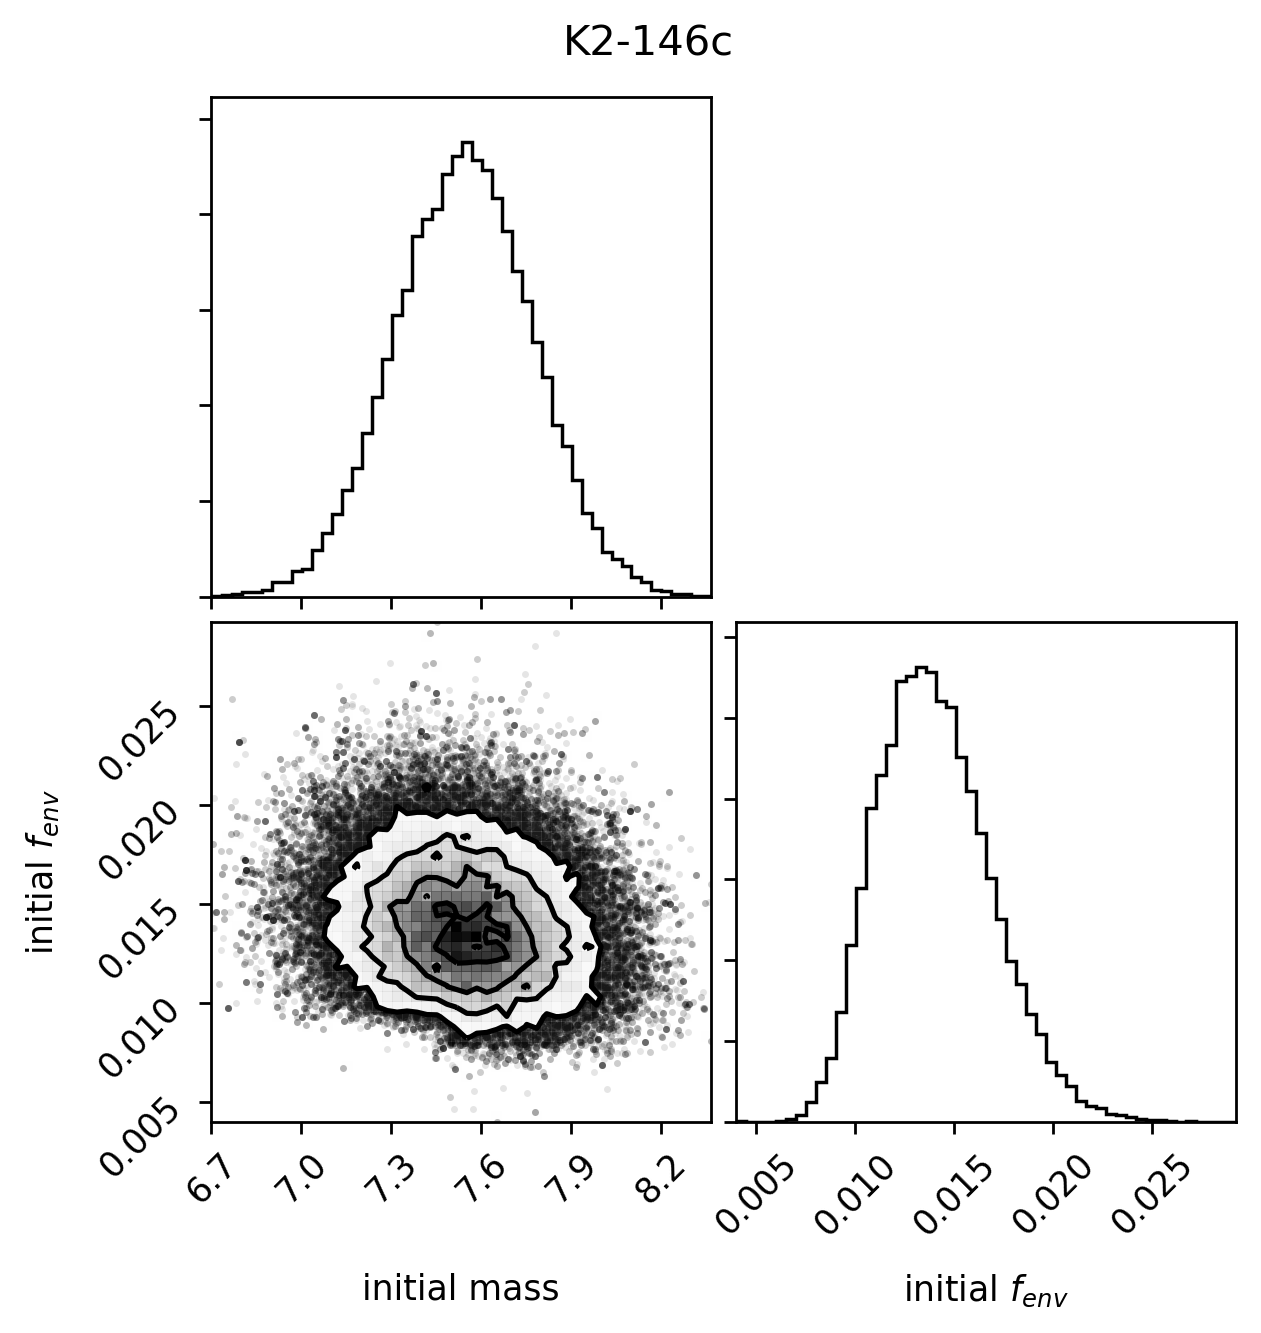

In [20]:
fig = corner.corner(samples,bins=50,labels=['initial mass','initial $f_{env}$'])
#levels=[0.1,0.3,0.6,0.95],
#,labels=['initial mass','initial $f_{env}$']
fig.set_dpi(250)
axs = fig.get_axes()
#axs[0].set_xlabel('initial mass')

axs[3].set_xticks(np.arange(0.005,0.03,0.005))
axs[2].set_yticks(np.arange(0.005,0.03,0.005))
axs[2].set_xticks(np.arange(6.7,8.4,0.3))
axs[0].set_xticks(np.arange(6.7,8.4,0.3))

#axs[2].set_xlim(6.95,8.05)
#fig.tight_layout()
fig.suptitle('K2-146c')

In [22]:
def final_f(mi, fi):
    mf = mass_interp(mi, fi)
    return 1.0 - (mi/mf) * (1 - fi) 

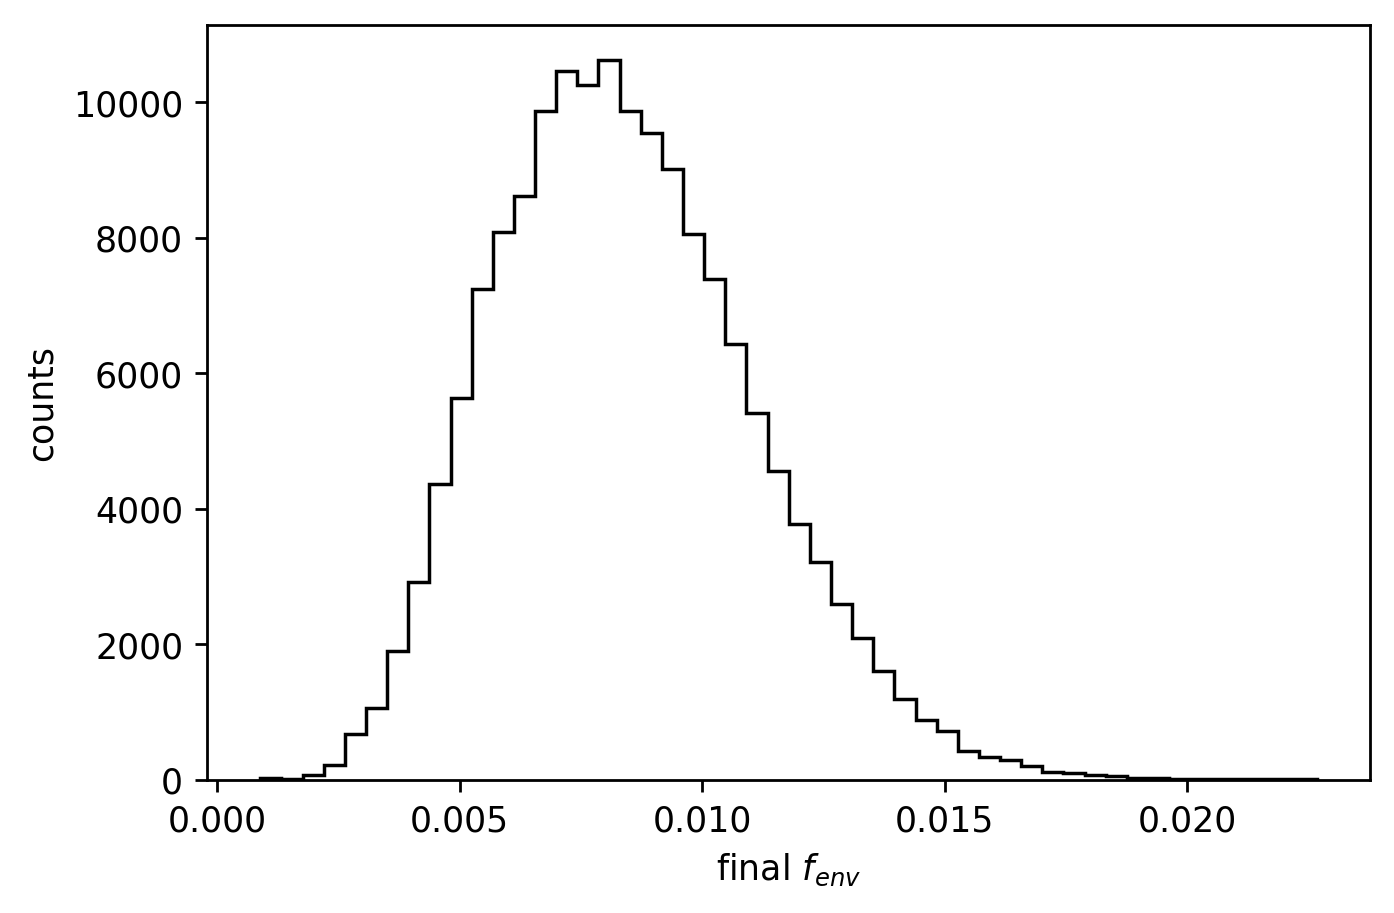

In [23]:
ffs = final_f(*samples.T)

plt.hist(ffs,50,color='k',histtype='step')
plt.gca().set_xlabel('final $f_{env}$')
plt.gca().set_ylabel('counts')
plt.gcf().set_dpi(250)

Text(0.5, 0, 'fraction of envelope mass lost')

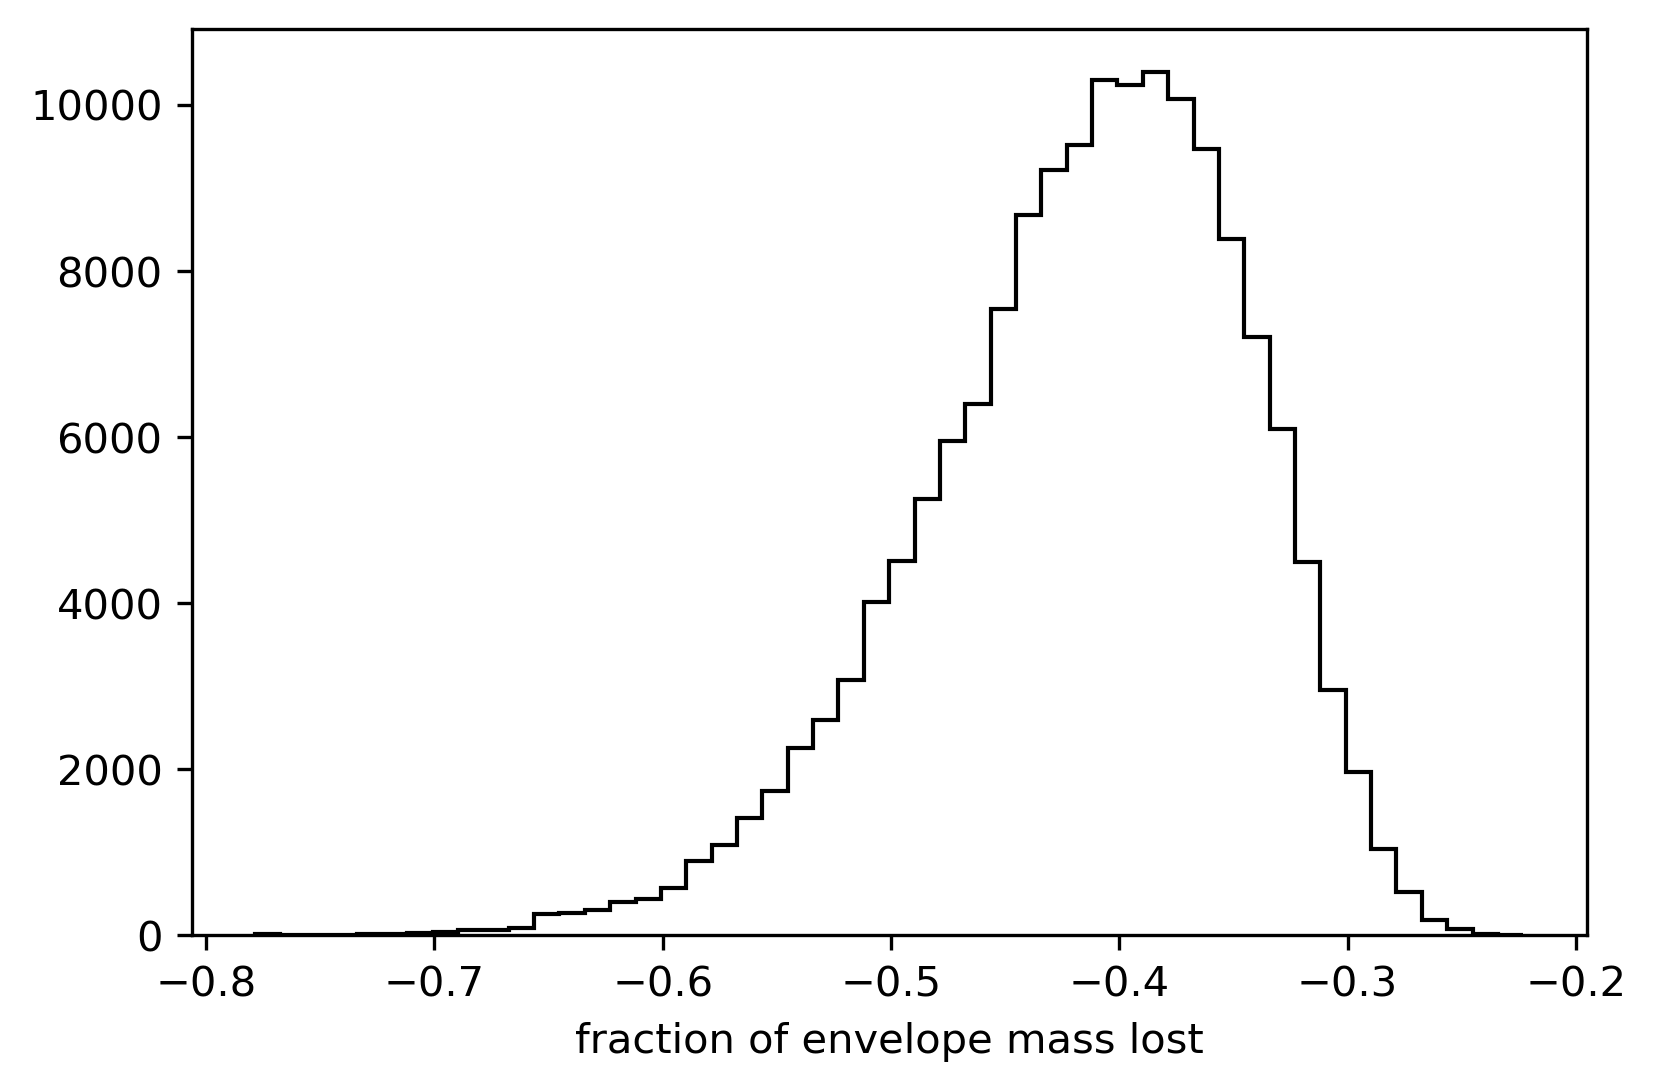

In [24]:
mfs = mass_interp(samples)
deltas = ((mfs * ffs) - (samples[:,0] * samples[:,1])) / (samples[:,0] * samples[:,1]) 

plt.hist(deltas,50,color='k',histtype='step')
plt.gcf().set_dpi(300)
plt.gca().set_xlabel('fraction of envelope mass lost')